# Installation

For LAV students: follow the procedure layed out in [getting started](https://github.com/LAV-ESG/getting-started).

1. Download the .whl file of the latest release from https://github.com/LAV-ESG/ipython_psql_extension/releases/latest.
2. Open a console in the folder you downloaded the file to, and run:
```bash
pip install [name of the file you downloaded]
```

# Loading the extension

Loading the extension is as simple as:

In [1]:
%load_ext ipython_pg.LAV

We use the LAV-module as it comes preconfigured to connect to our server. To establish a connect, use the '%pg_connect' magic as shown below. The server name and port are already set to the correct values; the only argument you have to supply is "dbname", the name of the database that you wish to connect to. 
Note that by default, the module uses your system login name as a username for postgres. If the two don't match, use the "user" argument to provide the correct username. Also, the module assumes to find the SSL certificate in the user's home directory (see installation); if you don't want to store the certificate there, you can specify an alternative path using the "sslcert" argument.

# Connecting to the database

In the following we will connect to the 'gis_data' database. If you execute the next line, and the server is reachable, then you will be prompted to type your password. Go ahead and try:

In [2]:
%pg_connect dbname='gis_data'

SUCCESS: connected to lav-fileserver.ethz.ch
  PostGIS integration enabled

# Browsing through the available data

OK! You are ready to explore the database. In case you are new to relational databases, postgres organizes data into tables. A table is defined by a set of columns; a column is defined by a unique name and a datatype (integers, text, ...). Data are stored as rows. Taken individually, a row (or record) can essentially be considered as a C "struct": a well-defined logical collection of individual bits of information, structured into fields; the fields are not necessarily of the same datatype.

Tables are grouped in logical structures called schemas in Postgres. To list all schemas in the connected database (available since ipython_pg 1.0.1):

In [3]:
%pg_info Kanton

table_name,table_description,owner
Aargau,(no description),db-admin
Appenzell Ausserrhoden,(no description),db-admin
Appenzell Innerrhoden,(no description),db-admin
BIP Kanton,(no description),db-admin
Basel-Landschaft,(no description),db-admin
Basel-Stadt,(no description),db-admin
Bern,(no description),db-admin
Cells to Kanton 2010,(no description),db-admin
Cells to Kanton 2011,(no description),db-admin
Cells to Kanton 2012,(no description),db-admin


To list all tables in a schema:

In [4]:
%pg_info "Individual Cell"

table_name,table_description,owner
Built-up Area,(no description),db-admin
Ground Use,(no description),db-admin
Ground Use 2004-2009,(no description),db-admin
Ground Use 2013-2018,(no description),db-admin
Ground Use BC,(no description),db-admin
Ground Use BC2,(no description),db-admin
MeteoTest,(no description),db-admin
NOAS04,(no description),db-admin
NOAS04g,(no description),db-admin
Total Roof-top Area and Energy,(no description),db-admin


And to view the columns of a table:

In [5]:
%pg_info "Individual Cell"."Built-up Area"

name,type,description
x_coord,int4(32),None
y_coord,int4(32),None
area,int4(32),None


# Accessing data

## Introducing SQL: the Structured Query Language
Data are accessed using a special-purpose programming language, called SQL (Structured Query Language) - often pronounced "sequel". Contrary to general purpose languages such as Python or C, SQL is a (mostly) declarative language. Simply put, this means that you describe what you want the final result to look like, rather than the steps the computer should take to get there. If you are used to imperative programmig, this may be a bit strange at first; it just takes some time to get your brain to "think SQL". 

In any case, the important message here is that, in SQL, you describe the data you want to retrieve - you don't really instruct the computer how to do it. Generally, you would state what columns from what tables interest you, what attributes these data should have (in case you are not interested in the entire table) and if these data should have any transformations applied to them. You then send this description to the server, which processes it and sends you back the results. 

## Talking to the server using psycopg2
The act of asking the server for data is called "querying the database"; your inquiry, the SQL statement you sent, is called "query". The query starts out as a bit of text (in SQL). After making sure it's valid, the statement has to be "packaged" and sent to the server over the internet, following a well-defined communication protocol. All of this are handled by a small piece of software (in our case the psycopg2 library).

Unfortunately, it is not entirely that simple. There are some repetitive tasks such as connecting to the database, loading data in memory or converting between types that are incompatible between Python and Postgres that psycopg2 does not handle fully automatically. ipython_pg is a small wrapper around psycopg2 that hides some of this ugliness; and it's IPython integration provides magics that take you from SQL to analyzable data in 6 keystrokes. 

## Your first query: ``%%pg_sql`` to view data
In the following, we will be using the IPython extension to query the database. In particular, we'll use the %%pg_sql magic. It allows you to write and execute SQL directly within IPython cells. The full capabilities of the command are described in its docstring; run %pg_sql? in your notebook or console to access it.

In [6]:
%pg_sql?

Docstring:
Query the database.

Executes an SQL query against the open database connection and provides
access to the results. It can be be used both as a cell and line magic.

Usage as a line-magic:
   [<varname> = ]%pg_sql <sql>

Usage as cell magic:
   %%pg_sql [<varname>]
   <sql>

When used as a line-magic, the cursor used to query the database is
returned. It an either be stored in a variable, or will just be sent
to the default output (in which case it is accessible thorugh _*).

As a cell-magic, when used without the optional <varname> argument,
results are returned as an HTML table in a IPthon.display.HTML
instance. Note that, in order not to destabilize the browser, only the
first 500 rows are displayed. If however <varname> is specified, then
no output is provided, but instead the cursor that queried the database
is made available as a local variable of name <varname>.

Within <sql>, the values of variables declared within the IPython
session can be accessed by using string.

Now it's time to write some SQL. To tell the server that you want to retrieve data (as opposed to modifying or adding data) you use the select-command (yes, command - that is what the postgres docs call it; but that does not make SQL imperative: select is merely an agreed-upon keyword that puts the server into "data-retrieval mode").

As a first example, we'll run a basic select statement. It *selects* all records *from* the "Built-up Area" table in the "Individual Cell" schema, *where* the cell-*area* is larger than a certain threshold value; and it retrieves only the x_coord, y_coord and area columns of that table:

In [7]:
%%pg_sql
SELECT x_coord, y_coord, area from "Individual Cell"."Built-up Area" WHERE area > 400*2000

SUCCES: matched 13 rows


x_coord,y_coord,area
499000,115000,1142064
499000,117000,1206877
537000,151000,1127978
585000,219000,865953
599000,199000,1118303
609000,267000,1119848
611000,265000,1085037
611000,267000,1227751
679000,247000,887053
681000,245000,800126


A first important conclusion: the result of a query is a table (or at least something that has the structure of a table). You'll also notice one of the perks of using ``%%pg_sql``: the results are displayed as an HTML table for your inspection.

Feel free to play with the query above; see e.g. what happens if you double the threshold value? You can make more complicated expressions, e.g. by adding in other constraints with logical operators (```where area > ... and x_coord < ...```).

Some practical remarks:

1. PostgreSQL is peculiar about quotes (' and "). Text as data (imagine the *name* column in some *people* database) needs to be included in single quotes (''). Schema, table and column names need to be included in double quotes ("") if they contain anything else than lower-case letters or the underscore (_) sign. The error message you get when you do not respect this convention can be misleading - which makes quotes a classical pitfall for beginners.
2. We selected all columns that the table has explicity. You could achieve the same by using the asterisk-notation (``select * from``). 
3. It does not matter whether you write SQL keywords (``SELECT``, ``FROM``, ``WHERE``, etc.) in upper or lower case letters. Some people use all caps on keywords to emphasize the structure of the query; with long queries, I find that line breaks and indentation helps more.
4. If your query matches no data, a warning will be issued - no table will be displayed. 
5. To not overwhelm the browser, the HTML table is truncated at 500 lines; i.e. if your query returns 501 records, only 500 will be displayed.

## ``%%pg_tuple``: making data accessible to python

Now the above is nice for viewing the data, but if we want to work with it in the notebook, we need different tools. One option is ``%%pg_tuple``; it returns the results as a python tuple. The tuple holds a set of other tuples, one for each column. Specifying variable names on the ``%%pg_tuple``-line instructs the extension to make the data available as variables in the notebook:

In [8]:
%%pg_tuple data
SELECT x_coord, y_coord, area from "Individual Cell"."Built-up Area" WHERE area > 400*2000

SUCCES: matched 13 rows
 result stored under 'data'


In [9]:
len(data), len(data[0]), len(data[1]), len(data[2])

(3, 13, 13, 13)

You can specify multiple variables to directly unpack the tuple within ``%%pg_tuple``

In [10]:
%%pg_tuple x_coord, y_coord, my_area
SELECT x_coord, y_coord, area from "Individual Cell"."Built-up Area" WHERE area > 400*2000

SUCCES: matched 13 rows
 results stored under 


In [11]:
print(my_area)

(1142064, 1206877, 1127978, 865953, 1118303, 1119848, 1085037, 1227751, 887053, 800126, 1146191, 1078889, 886823)


## ``%pg_first`` and ``%pg_one``: quick access to single-row queries

Sometimes, a query is known to return just one row. The example below uses ``count()``, which instructs postgres to return the number of records matched by the query. In this scenario, ``%pg_first`` returns the first (and in this case only) record as tuple (in case there are multiple columns). ``%pg_one`` does the same, but in case the there is only one column, it takes the single entry out of its tuple and returns it directly.

Note that both are line-magics; their usage is a bit different (note how the data is retrieved):

In [12]:
count = %pg_first SELECT count(x_coord), count(y_coord) from "Individual Cell"."Built-up Area" WHERE area > 400*2000

SUCCES: matched 1 rows


In [13]:
print(count)

(13, 13)


In [14]:
%pg_one SELECT count(x_coord) from "Individual Cell"."Built-up Area" WHERE area > 400*2000

SUCCES: matched 1 rows


13

In case you forgot to store the result, IPython can come to your rescue

In [15]:
print(_)

13


And again, to show the advantage of ``%pg_one``:

In [16]:
%pg_first SELECT count(x_coord) from "Individual Cell"."Built-up Area" WHERE area > 400*2000

SUCCES: matched 1 rows


(13,)

## Working with cursors: ``%%pg_sql`` and ``%%pg_cursor``

There are cases where you need more fine-grained control over how the data is retrieved from the server. This means that you directly work with ``psycopg2``, but *ipython_pg* can still support you. Indeed, queries are always executed within a context; in postgres (and other relational databases) this is represented by a so called "cursor". Conceptually, the most tangible analogy is that of a service desk of a large company, say the Swiss Post: you do not talk to each departement separately, but rather access the company's services through the gateway of a service desk.  
Practically, a cursor is just an object through which you interact with the database. It is spawned from the connection object, 

``%%pg_sql`` displays HTML tables of the results by default. But if a variable name is provided as argument, then it returns the cursor it executed the query against instead. This gives you access to the data; this can be handy e.g. with very large datasets, as the cursor can be iterated record by record, instead of having to download everything at once:

In [17]:
%%pg_sql cur
SELECT x_coord, y_coord, area from "Individual Cell"."Built-up Area" WHERE area > 400*2000

SUCCES: matched 13 rows
 cursor object as 'cur'


In [18]:
type(cur)

psycopg2.extensions.cursor

The cursor is iteable:

In [19]:
next(cur)

(499000, 115000, 1142064)

You can loop over it using a for-loop (e.g.) or use it within an array comprehension. Also, it provides methods to scroll through the result dataset. The cursor always points to a certain record within the entire set. Be aware that it doesn't automatically rewind if it arrived at the last dataset:

In [20]:
for row in cur:
    pass
next(cur)

StopIteration: 

Alternatively, you can also work directly on cursors. The ``%pg_cursor`` line-magic gives you a fresh cursor to do with as you please:

In [21]:
cur = %pg_cursor
cur.execute('SELECT x_coord, y_coord, area from "Individual Cell"."Built-up Area" WHERE area > 400*2000')
next(cur)

(499000, 115000, 1142064)

Beware though that this also puts you in charge of error-handling. Syntax errors or other unexpected conditions corrupt the cursor. You then have to instruct the connection to "rollback" any transaction. The ``%pg_rollback`` magic makes this easy: 

In [22]:
cur = %pg_cursor
cur.execute('SELECT syntax-error')

ProgrammingError: column "syntax" does not exist
LINE 1: SELECT syntax-error
               ^


In [23]:
%pg_one select 1

ERROR: current transaction is aborted, commands ignored until end of transaction block



ProgrammingError: no results to fetch

As you can see, even though this last query is syntactically valid, it fails, unless you roll back the previous transaction:

In [24]:
%pg_rollback

In [25]:
%pg_one select 1

SUCCES: matched 1 rows


1

Note that executing the ``%pg_one select 1`` query a second time will resolve the issue too, because the magic's automatic error-handling issue a rollback on any error (including those not caused by it).

# Convenience features for the lazy

## Dynamic variable substitution

So far, you have to hard-code queries completely. But imagine that you are trying out different threshold values in the previous "area"-query and you compute them in your notebook. You'd have to copy the calculated value into the SQL-text at every iteration - very tedious! This is why we have variable substitution instead: the expression `<expr>` within a `${<expr>}` tag in your queries will be replaced by the corresponding value within the notebook's namespace. 

`<expr>` can be any valid Python expression as long as :

1. it does not contain the character "`}`"
2. it evaluates to something that can be `str`-ed to valid sql

In [6]:
my_variable =  3.141516

In [7]:
%%pg_one
SELECT ${my_variable * np.pi}

SUCCES: matched 1 rows


Decimal('9.869363586734794')

You can also pass in SQL identifiers, using the `:i` flag. The expression left of the flag must evaluate either to an iterable of strings (they will be joined back together using `.` to express qualified table names) or to a string. *Note*: the backend takes care of quoting the identifiers where necessary, so do not do that manually:

Using a tuple:

In [4]:
%%pg_one
SELECT x_coord, y_coord, area 
from ${("Individual Cell", "Built-up Area"):i} WHERE area > 400*2000

SUCCES: matched 13 rows


(499000, 115000, 1142064)

Using a string:

In [5]:
%%pg_one
SELECT x_coord, y_coord, area 
from ${"Individual Cell.Built-up Area":i} WHERE area > 400*2000

SUCCES: matched 13 rows


(499000, 115000, 1142064)

Incorrect usage using literal quotes:

In [30]:
%%pg_one
SELECT x_coord, y_coord, area 
from ${'"Individual Cell"."Built-up Area"':i} WHERE area > 400*2000

ERROR: relation ""Individual Cell"."Built-up Area"" does not exist
LINE 2: from """Individual Cell"""."""Built-up Area""" WHERE area > ...
             ^



ProgrammingError: no results to fetch

## Green mode
One of the annoyances of psycopg2 is that long-running queries can't be aborted. Your query has been running for minutes, and suddenly you realize that it's actually wrong. So you start hitting "interrupt" or "Ctrl+C", but nothing happens. So you either wait, or restart your interpreter and loose all your data in memory.

The "green_mode" module (activated by default) uses the coroutine support introduced in psycopg2 to make psycopg2 listen for interrupts - and thus enables you to abort queries. Just try it out: run the query blow and interrupt the kernel. The keyboard-interrupt exeption will be risen, but only after the server is done sleeping:

In [31]:
import ipython_pg.green_mode
ipython_pg.green_mode.deactivate()

In [32]:
%pg_sql select pg_sleep(10)

KeyboardInterrupt: 

Now, let's try this again with green-mode activated:

In [33]:
ipython_pg.green_mode.activate()

In [34]:
%pg_sql select pg_sleep(10)

ERROR: canceling statement due to user request



<cursor object at 0x0000019F7A794BA8; closed: 0>

## PostGIS integration

The PostGIS integration registers a set of adapters and types, that dynamically and transparently convert PostGIS types to Shapely BaseGeometries for Python and vis-versa (note: depends on Shapely).

In [35]:
import shapely.geometry

In [36]:
p = shapely.geometry.Point(4, 45)

SUCCES: matched 1 rows
 result stored under 'one'


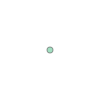

In [37]:
%%pg_one one
select st_transform(st_setsrid(${p}::geometry, 4326), 2056)

# Reading data as pandas dataframe:

It is now possible to read in data straight to a pandas DataFrame:

In [38]:
%%pg_pd
SELECT x_coord, y_coord, area from "Individual Cell"."Built-up Area" 
WHERE area > 400*2000
limit 3

SUCCES: matched 13 rows


,x_coord,y_coord,area
0,499000,115000,1142064
1,499000,117000,1206877
2,537000,151000,1127978
3,585000,219000,865953
4,599000,199000,1118303
5,609000,267000,1119848
6,611000,265000,1085037
7,611000,267000,1227751
8,679000,247000,887053
9,681000,245000,800126


Just as with cursors, a name under which the dataframe will be available can be specified. Furthermore, the `--idx` argument allows to specify an index (or multi-index, as in the example below)

In [39]:
%%pg_pd dta --idx x_coord y_coord
SELECT x_coord, y_coord, area from "Individual Cell"."Built-up Area" WHERE area > 400*2000

SUCCES: matched 13 rows
 results stored as 'dta'


In [40]:
dta

area
x_coord y_coord         
499000  115000   1142064
        117000   1206877
537000  151000   1127978
585000  219000    865953
599000  199000   1118303
609000  267000   1119848
611000  265000   1085037
        267000   1227751
679000  247000    887053
681000  245000    800126
        247000   1146191
683000  247000   1078889
        251000    886823

# Pushing DataFrames to the server

The extension now has the `%pg_copy` magic: it pushes the contents of a dataframe to a table on the connected server. That table must exist before pushing data, so let's first take care of that:

In [41]:
%%pg_sql
create temporary table test (
    x_coord int,
    y_coord int,
    area numeric
)

SUCCESS: query did not return any data


Then simply specify the variable name (or any python expression evaluating to a dataframe, as long as the expression does not contain any white space) and the target table:

In [42]:
%pg_copy dta test

  waring: green-mode temporarily deactivated (interrupt won't abort the import)  green mode reactivated

Note that `COPY` does not work in `green-mode`, so it is temporarily turned off. That means that an interrupt will not directly abort the copy operation. However, to reduce the memory foot-print, `%pg_copy` now uploads data (as CSV) in chunks of 10000 (by default; different values can be set with the `--chunk` argument). On a long import, the interrupt will thus typically affect the transition to another chunk.

In [43]:
%%pg_sql
select * from test

SUCCES: matched 13 rows


x_coord,y_coord,area
115000,1142064,499000
117000,1206877,499000
151000,1127978,537000
219000,865953,585000
199000,1118303,599000
267000,1119848,609000
265000,1085037,611000
267000,1227751,611000
247000,887053,679000
245000,800126,681000


In [44]:
%pg_sql drop table test

SUCCESS: query did not return any data


<cursor object at 0x0000019F7A7949E8; closed: 0>

*Note on GeoDataFrames*: uploading `GeoDataFrames` works too, but as `shapely` does not specify the coordinate system of the data, there will be an issue. The workaround is to temporarily update the table SRID to 0 and then reset it to the proper value later, using  [UpdateGeinetrySRID](https://postgis.net/docs/UpdateGeometrySRID.html).

# Prepared statements

The ` %%pg_prepare` cell-magic creates prepared statements and makes them accessible as functions:

In [7]:
%%pg_prepare built_area --idx x_coord
SELECT x_coord, y_coord, area 
from ${("Individual Cell", "Built-up Area"):i} WHERE area > $1
limit 10

 prepared-statement at 'built_area'


The function returns a cursor

In [8]:
built_area(200).fetchone()

(485000, 109000, 628)

But using the `as_dataframe` or `df` argument, the output will be returned as pandas dataframe:

In [9]:
built_area(200, as_dataframe=True).iloc[:3]

,y_coord,area
x_coord,,
485000,109000,628
485000,111000,49374
485000,113000,2802


Note that:

1. the `--idx` argument works the same as with `%pg_pd` (if the `as_dataframe` or `df` flag is used). 
2. templating using `${<expr}` is supported.

# Access to the connection object

In [42]:
conn = %pg_connection

In [ ]:
conn.rollback()

And when you are done, do not forget to:

In [8]:
%pg_disconnect